In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import *
from sklearn.metrics import mean_absolute_error

from model.utils.tools import StandardScaler, load_data_timeindex, load_data_DFM, set_lag_missing, repeat_label_row


c:\Users\PC\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
target = 'A1' # GDP grow ratio
seq_len = 6
flag = "train"

root = "D:/2023/SVU_SCT_FIN/SVU_SCT_FIN_SP/SVU_SCT_FIN/Model/BIVA/Base_data/"
file = "dataset_03_S.xlsx"
path = os.path.join(root,file)
df_Q, df_Q_trans, df_M, df_M_trans, var_info = load_data_timeindex(path)

period = {'M': ['2000-01','2023-01'], 'Q':['2000-03','2023-03']}
df_M = df_M.loc[period['M'][0]:period['M'][1]]
df_Q = df_Q.loc[period['Q'][0]:period['Q'][1]]

cols_M = list(df_M.columns)
cols_Q = list(df_Q.columns)
cols_Q.remove(target)
df_Q = df_Q[cols_Q + [target]]


type_map = {'train': 0, 'val': 1, 'test': 2}
set_type = type_map[flag]

num_train = int(len(df_M) * 0.8) 
num_test = int(len(df_M) * 0.1)
num_vali = len(df_M) - num_train - num_test
border1s = [0, num_train - seq_len, len(df_M) - num_test - seq_len]
border2s = [num_train, num_train + num_vali, len(df_M)]
border1 = border1s[set_type]
border2 = border2s[set_type]

border1s_Q = [0, (num_train - seq_len)//3, (len(df_M) - num_test - seq_len)//3]
border2s_Q = [num_train//3, (num_train + num_vali)//3, len(df_M)//3]
border1_Q = border1s_Q[set_type]
border2_Q = border2s_Q[set_type]

df_data = df_M[cols_M]
df_data_t = df_Q[[target]]

scaler_m = StandardScaler()
scaler_q = StandardScaler()

train_data = df_data[border1s[0]:border2s[0]]
df_data_cols = df_data.columns
df_data_index = df_data.index

train_data_t = df_data_t[border1s_Q[0]:border2s_Q[0]]
df_data_t_cols = df_data_t.columns
df_data_t_index = df_data_t.index

scaler_m.fit(train_data.values)
data = scaler_m.transform(df_data.values)
scaler_q.fit(train_data_t.values)
data_t = scaler_q.transform(df_data_t.values)

Q_mean = scaler_q.mean
Q_std = scaler_q.std 
print(f"Q_mean : {Q_mean}")
print(f"Q_std : {Q_std}")

In [27]:
def Metric(pred, true_y, mean, std):

        #prepare
        result = pred[:]
        label = true_y[:]
        print(f"result.shape, label.shape: {result.shape}, {label.shape}")
        print(f"result[0]: {result[0]}")

        result_scale = (result*std) + mean
        label_scale = (label*std) + mean

        #MAE
        # MAE = mean_absolute_error(label, result)
        sumout = 0
        for id in range(result.shape[0]):
          out = mean_absolute_error(label[id],result[id])
          sumout += out
        MAE = sumout/(result.shape[0])
        print(f"MAE : {MAE}")

        #MSE
        sumout = 0
        for id in range(result.shape[0]):
          out = mean_squared_error(label[id],result[id])
          sumout += out
        MSE =  sumout/(result.shape[0])
        print(f"MSE : {MSE}")

        # RMSE (Root Mean Squared Error)
        sumout = 0
        for id in range(result.shape[0]):
          out = mean_squared_error(label[id],result[id])
          sumout += np.sqrt(out)
        RMSE =  sumout/(result.shape[0])
        print(f"RMSE : {RMSE}")

        #MAPE (Mean Absolute Percentage Error)
        sumout = 0
        for id in range(result.shape[0]):
          out = np.mean(np.abs((label[id] - result[id]) / label[id])) * 100 
          sumout += out
        N_MAPE = sumout/(result.shape[0])
        print(f"norm_MAPE : {N_MAPE}")

        #MAPE_scale (Mean Absolute Percentage Error)
        sumout = 0
        for id in range(result_scale.shape[0]):
          out = np.mean(np.abs((label_scale[id] - result_scale[id]) / label_scale[id])) * 100 
          sumout += out
        MAPE = sumout/(result_scale.shape[0])
        print(f"denorm_MAPE : {MAPE}")
        return MAE, MSE, RMSE, N_MAPE, MAPE

In [28]:
pred = np.load("C:/Users/PC/Downloads/BIVA_pred.npy")
true = np.load("C:/Users/PC/Downloads/BIVA_trues.npy")
print(f"pred.shape: {pred.shape}")
print(f"true.shape: {true.shape}")

MAE, MSE, RMSE, norm_MAPE, MAPE = Metric(pred, true, Q_mean, Q_std)


pred.shape: (28, 1, 1)
true.shape: (28, 1, 1)
result.shape, label.shape: (28, 1, 1), (28, 1, 1)
result[0]: [[-0.3949244]]
MAE : 0.5552071183919907
MSE : 0.42724806055360076
RMSE : 0.5552071183919907
norm_MAPE : 145.88428501571929
denorm_MAPE : 168.35953038043837


In [55]:
result_scale = (pred*Q_std) + Q_mean
label_scale = (true*Q_std) + Q_mean
label_scale = label_scale.reshape([28]).astype(np.float32)
result_scale = result_scale.reshape([28]).astype(np.float32)
#result_scale
np.sum(np.abs((label_scale - result_scale)/label_scale))/28



1.6835952486310686

In [3]:
input = np.load("D:/2023/SVU_SCT_FIN/SVU_SCT_FIN_SP/SVU_SCT_FIN/Model/BIVA/exp/(BIVA)_result/BIVA-no1-dt20230802-seq6-pred1-bt1-lr0.15-mv6-v3x3/BIVA_inputs.npy")
imputation = np.load("D:/2023/SVU_SCT_FIN/SVU_SCT_FIN_SP/SVU_SCT_FIN/Model/BIVA/exp/(BIVA)_result/BIVA-no1-dt20230802-seq6-pred1-bt1-lr0.15-mv6-v3x3/BIVA_imputation.npy")
reconstruct = np.load("D:/2023/SVU_SCT_FIN/SVU_SCT_FIN_SP/SVU_SCT_FIN/Model/BIVA/exp/(BIVA)_result/BIVA-no1-dt20230802-seq6-pred1-bt1-lr0.15-mv6-v3x3/BIVA_recons.npy")
prediction = np.load("D:/2023/SVU_SCT_FIN/SVU_SCT_FIN_SP/SVU_SCT_FIN/Model/BIVA/exp/(BIVA)_result/BIVA-no1-dt20230802-seq6-pred1-bt1-lr0.15-mv6-v3x3/BIVA_pred.npy")
groundtrues = np.load("D:/2023/SVU_SCT_FIN/SVU_SCT_FIN_SP/SVU_SCT_FIN/Model/BIVA/exp/(BIVA)_result/BIVA-no1-dt20230802-seq6-pred1-bt1-lr0.15-mv6-v3x3/BIVA_trues.npy")

In [14]:
df = pd.DataFrame(imputation[0])
df.plot()

<AxesSubplot:>

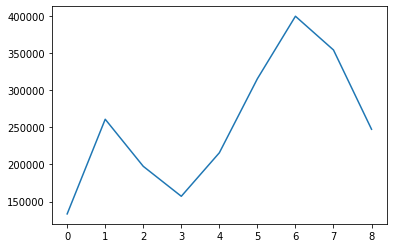

In [8]:
plt.plot(test_loss)

In [12]:
for epoch in range(0,10):
    lr = 0.15 * (0.955 ** (epoch // 1))
    print(f"epoch : {epoch}  ==> lr : {lr}")

epoch : 0  ==> lr : 0.15
epoch : 1  ==> lr : 0.14325
epoch : 2  ==> lr : 0.13680375
epoch : 3  ==> lr : 0.13064758124999998
epoch : 4  ==> lr : 0.12476844009374997
epoch : 5  ==> lr : 0.11915386028953123
epoch : 6  ==> lr : 0.11379193657650231
epoch : 7  ==> lr : 0.10867129943055971
epoch : 8  ==> lr : 0.10378109095618451
epoch : 9  ==> lr : 0.09911094186315621
